In [1]:
import glob
import os
import json
import pickle as pkl
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
outdir = "/Users/fmokhtar/Desktop/AN_2024/"

In [4]:
with open("tets/outfiles/0-1.pkl", "rb") as f:
    out = pkl.load(f)

In [6]:
def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[year][sample]["sumgenweight"]
    return sum_sumgenweight


def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

In [8]:
! ls ../eos/July23_triggerSF_2018

SingleMuon_Run2018A SingleMuon_Run2018C TTTo2L2Nu           TTToSemiLeptonic
SingleMuon_Run2018B SingleMuon_Run2018D TTToHadronic


In [41]:
### key=label, value=sample
samples_dict = {
    "2018": {
        "Data": [
            "SingleMuon_Run2018A",
            "SingleMuon_Run2018B",
            "SingleMuon_Run2018C",
            "SingleMuon_Run2018D",
        ],
        "TTTo2L2Nu": [
            "TTTo2L2Nu",
        ],
        "TTToHadronic": [
            "TTToHadronic",
        ],
        "TTToSemiLeptonic": [
            "TTToSemiLeptonic",
        ],
    },
    "2017": {
        "Data": [
            "SingleMuon_Run2017B",
            "SingleMuon_Run2017C",
            "SingleMuon_Run2017D",
            "SingleMuon_Run2017E",
            "SingleMuon_Run2017F",
        ],
        "TTTo2L2Nu": [
            "TTTo2L2Nu",
        ],
        "TTToHadronic": [
            "TTToHadronic",
        ],
        "TTToSemiLeptonic": [
            "TTToSemiLeptonic",
        ],
    },    
    "2016APV": {
        "Data": [
            "SingleMuon_Run2016B_ver2_HIPM",
            "SingleMuon_Run2016C_HIPM",
            "SingleMuon_Run2017D",
            "SingleMuon_Run2016D_HIPM",
            "SingleMuon_Run2016E_HIPM",
            "SingleMuon_Run2016F_HIPM",
            
        ],
        "TTTo2L2Nu": [
            "TTTo2L2Nu",
        ],
        "TTToHadronic": [
            "TTToHadronic",
        ],
        "TTToSemiLeptonic": [
            "TTToSemiLeptonic",
        ],
    },
    "2016": {
        "Data": [
            "SingleMuon_Run2016F",
            "SingleMuon_Run2016G",
            "SingleMuon_Run2016H",
        ],
        "TTTo2L2Nu": [
            "TTTo2L2Nu",
        ],
        "TTToHadronic": [
            "TTToHadronic",
        ],
        "TTToSemiLeptonic": [
            "TTToSemiLeptonic",
        ],
    },
}

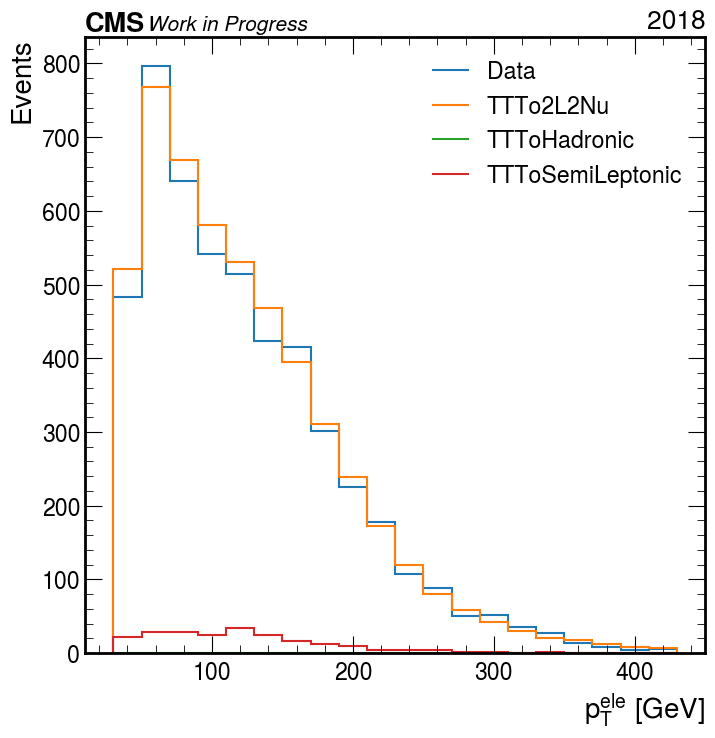

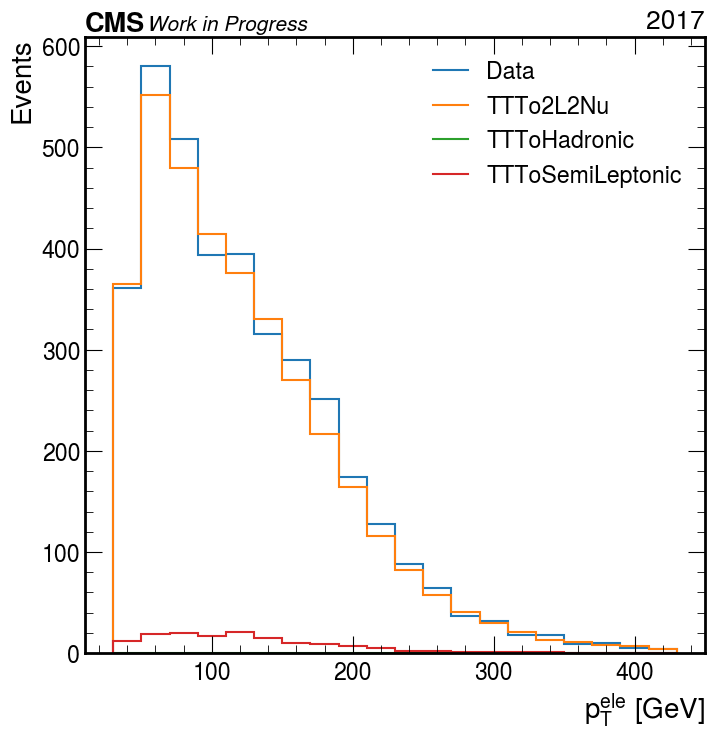

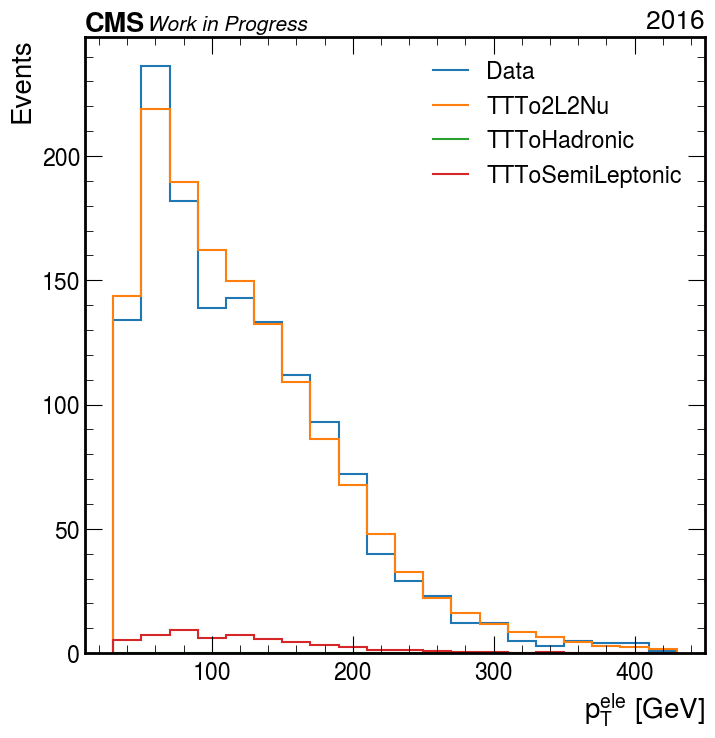

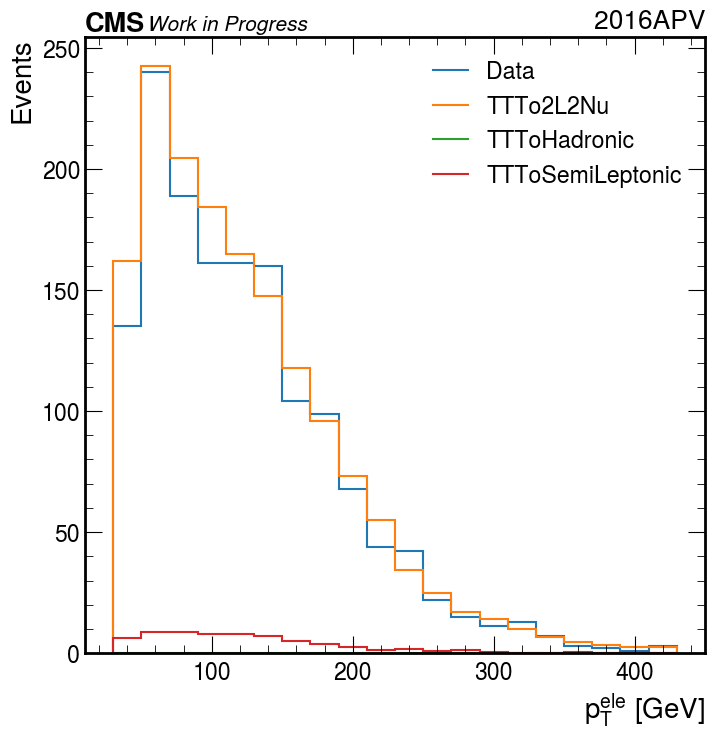

In [42]:
ch = "ele"

years = [
    "2018",
    "2017",
    "2016",
    "2016APV",    
]

for year in years:

    hists = hist2.Hist(
        hist2.axis.StrCategory([], name='samples', growth=True),
        hist2.axis.Variable(np.linspace(30, 430, 21), name='leppt', label=r'$p_T^{ele}$ [GeV]', overflow=False),
    )
    
    # get lumi
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch][year]

    for sample_label in samples_dict[year]:

        if sample_label == "Data":
            isData = True
        else:
            isData = False    

        for sample in samples_dict[year][sample_label]:

            pkl_files = glob.glob(f"../eos/July23_triggerSF_{year}/{sample}/outfiles/*.pkl")
            xsecweight = get_xsecweight(pkl_files, year, sample, isData, luminosity)

            # loop over all files of that sample
            X = []
            weights = []
            for i, file in enumerate(pkl_files):
                with open(file, "rb") as f:
                    out = pkl.load(f)[year][sample]["skimmed_events"]["ele"]

                X += list(out["vars"]["ele_pt"])
                if not isData:           
                    weights += list(out["weights"]["weight_genweight"])

            X = np.array(X)

            if isData:
                hists.fill(
                    samples=sample_label,        
                    leppt=X,
                )

            else:
                weights = np.array(weights)             
                weights *= xsecweight     

                hists.fill(
                    samples=sample_label,        
                    leppt=X,
                    weight=weights,
                )
        
    fig, ax = plt.subplots(figsize=(8,8))

    for sample in hists.axes["samples"]:
        hists[{"samples": sample}].project("leppt").plot1d(label=sample)

    # plt.yscale("log")
    plt.legend()
    plt.ylim(0)
    plt.ylabel("Events")
    hep.cms.lumitext(
        year, ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

    plt.savefig(f"{outdir}/eletriggerSF/{ch}_{year}_1d_leppt.pdf")        

# Electron trigger scale factors

In [11]:
! ls ../eos/July23_triggerSF_2017/

SingleMuon_Run2017B SingleMuon_Run2017D SingleMuon_Run2017F TTToHadronic
SingleMuon_Run2017C SingleMuon_Run2017E TTTo2L2Nu           TTToSemiLeptonic


In [12]:
### key=label, value=sample
samples_dict = {
    "2018": {
        "Data": [
            "SingleMuon_Run2018A",
            "SingleMuon_Run2018B",
            "SingleMuon_Run2018C",
            "SingleMuon_Run2018D",
        ],
        "Simulation": [
            "TTTo2L2Nu",
            "TTToHadronic",
            "TTToSemiLeptonic",
        ],
    },
    "2017": {
        "Data": [
            "SingleMuon_Run2017B",
            "SingleMuon_Run2017C",
            "SingleMuon_Run2017D",
            "SingleMuon_Run2017E",
            "SingleMuon_Run2017F",
        ],
        "Simulation": [
            "TTTo2L2Nu",
            "TTToHadronic",
            "TTToSemiLeptonic",
        ],
    },    
    "2016APV": {
        "Data": [
            "SingleMuon_Run2016B_ver2_HIPM",
            "SingleMuon_Run2016C_HIPM",
            "SingleMuon_Run2017D",
            "SingleMuon_Run2016D_HIPM",
            "SingleMuon_Run2016E_HIPM",
            "SingleMuon_Run2016F_HIPM",
            
        ],
        "Simulation": [
            "TTTo2L2Nu",
            "TTToHadronic",
            "TTToSemiLeptonic",
        ],
    },
    "2016": {
        "Data": [
            "SingleMuon_Run2016F",
            "SingleMuon_Run2016G",
            "SingleMuon_Run2016H",
        ],
        "Simulation": [
            "TTTo2L2Nu",
            "TTToHadronic",
            "TTToSemiLeptonic",
        ],
    },
}

legend_lab = {
    "120": r"$p_T$ < 120 GeV",
    "200-": r"120 < $p_T$ < 200 GeV",
    "200+": r"$p_T$ > 200 GeV",    
}
def unc_fraction(num, den, unc_num=None, unc_den=None):
    
    """if either unc_num/unc_den are None, will use poissonian."""
    
    sf = num/den
    
    if unc_num is None:
        unc_num = np.sqrt(num)   # TODO: do not take poisson

    if unc_den is None:
        unc_den = np.sqrt(den)
    
    # propagate from the eff calculation + eff_unc of Data and Sim
    # binomial error^2 = (p*(1-p))/N
    
    sf_unc = sf * np.sqrt( (unc_num/num)**2 + (unc_den/den)**2 )    
    
    return sf_unc

In [13]:
ch = "ele"

HLT_triggers = {}
with open("../boostedhiggs/data/triggers.json", "rb") as f:
    trg = json.load(f)

for year in trg:
    HLT_triggers["UL" + year[2:]] = [("HLT_" + i) for i in trg[year][ch]]

HLT_triggers    

{'UL16': ['HLT_Ele27_WPTight_Gsf',
  'HLT_Ele115_CaloIdVT_GsfTrkIdT',
  'HLT_Photon175'],
 'UL17': ['HLT_Ele35_WPTight_Gsf',
  'HLT_Ele115_CaloIdVT_GsfTrkIdT',
  'HLT_Photon200'],
 'UL18': ['HLT_Ele32_WPTight_Gsf',
  'HLT_Ele115_CaloIdVT_GsfTrkIdT',
  'HLT_Photon200']}

In [14]:
ptbinning = [2000, 200, 120, 30]
etabinning = [-2.5, -1.5, -0.5,  0.5,  1.5,  2.5]

In [30]:
years = {
    "UL18": ["2018"],
    "UL17": ["2017"],
    "UL16": ["2016", "2016APV"],
}

SF = {}
for yearkey in years:
    SF[yearkey] = np.zeros((len(ptbinning)-1,len(etabinning)-1))

SF    

{'UL18': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 'UL17': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 'UL16': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])}

Processing year UL18
ptcut 200+
-------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ptcut 200-
-------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ptcut 120
-------------------------------------
Processing year UL17
ptcut 200+
-------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ptcut 200-
-------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ptcut 120
-------------------------------------
Processing year UL16
ptcut 200+
-------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ptcut 200-
-------------------------------------
ptcut 120
-------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


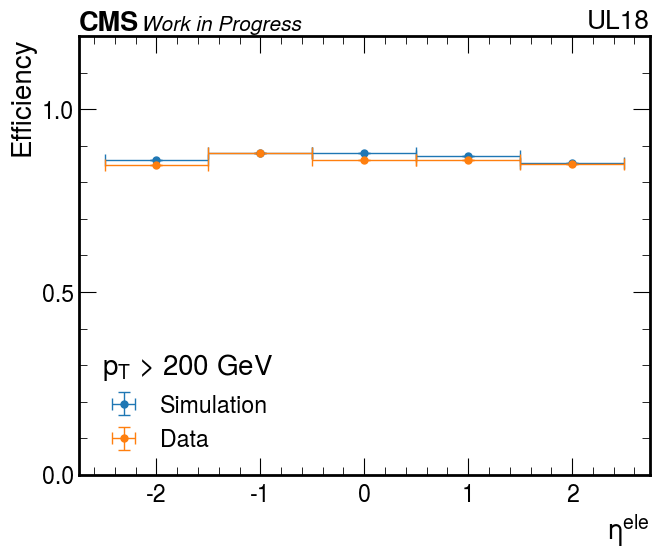

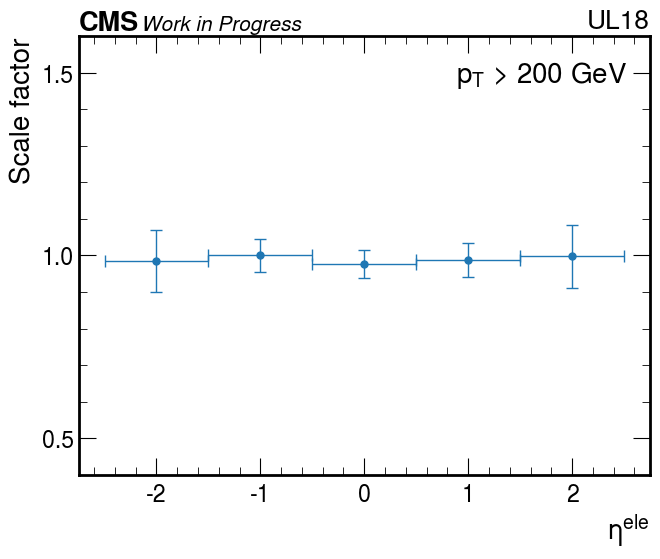

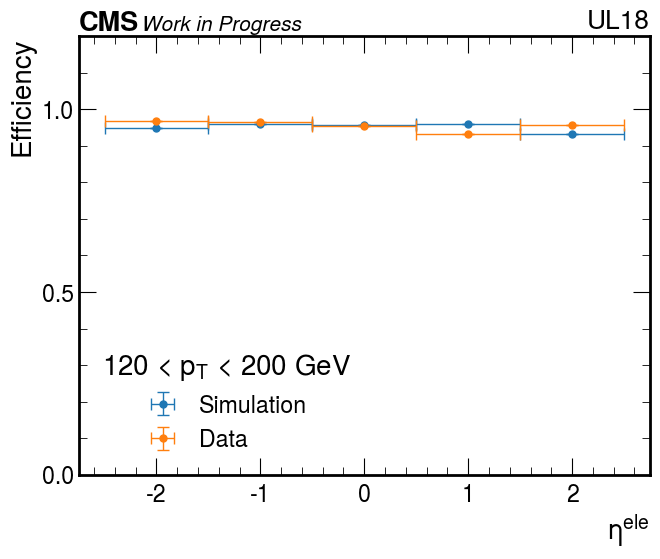

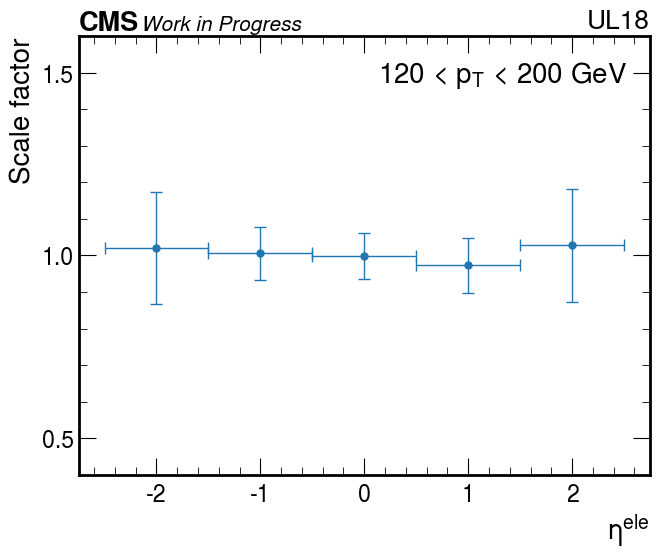

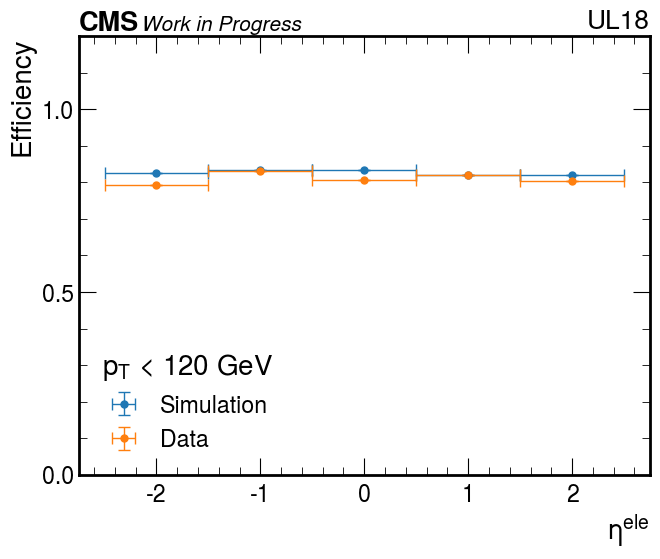

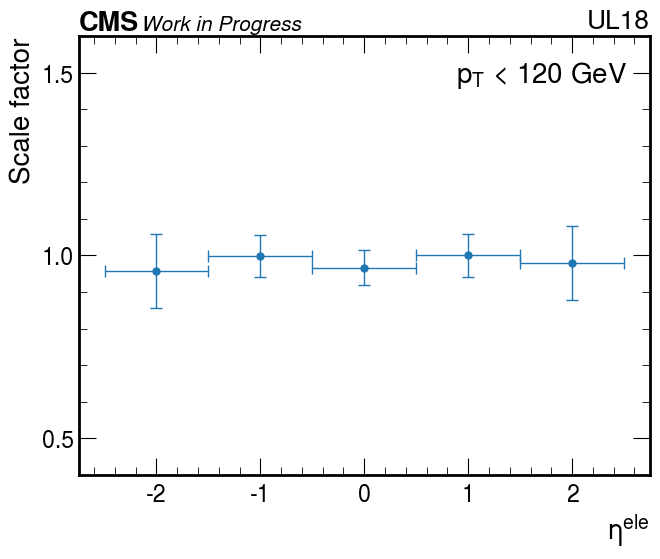

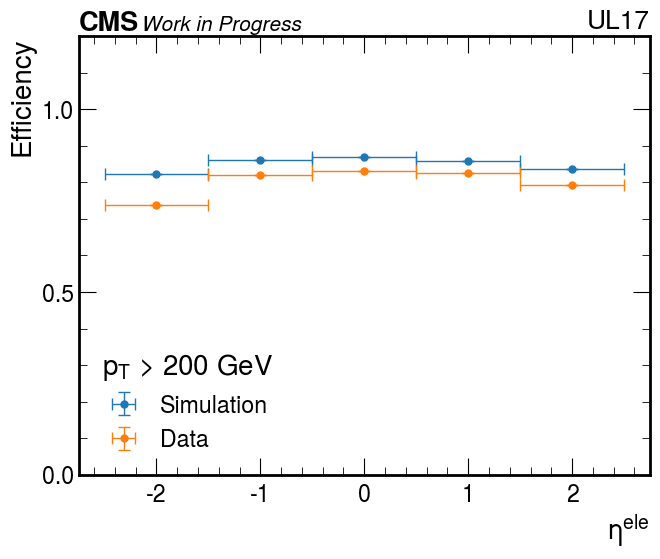

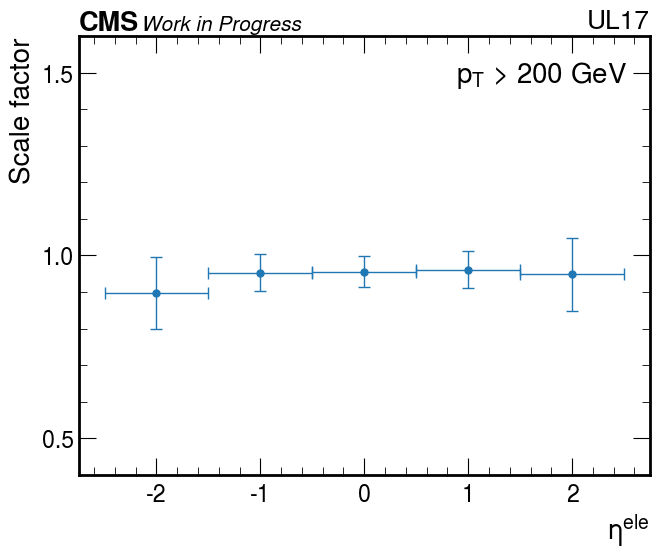

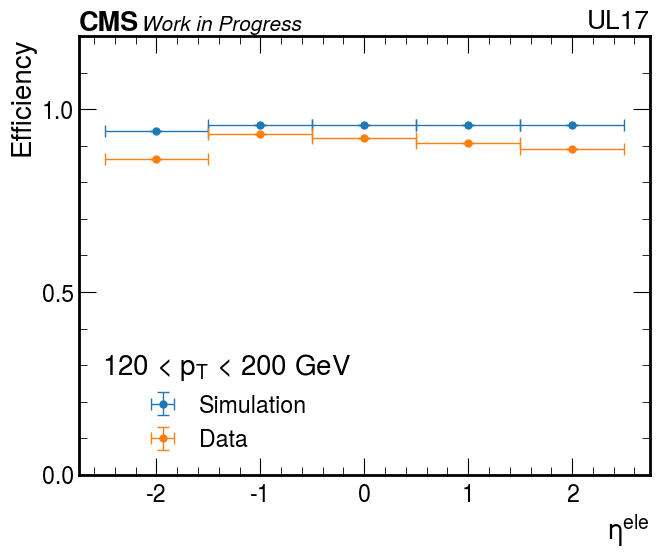

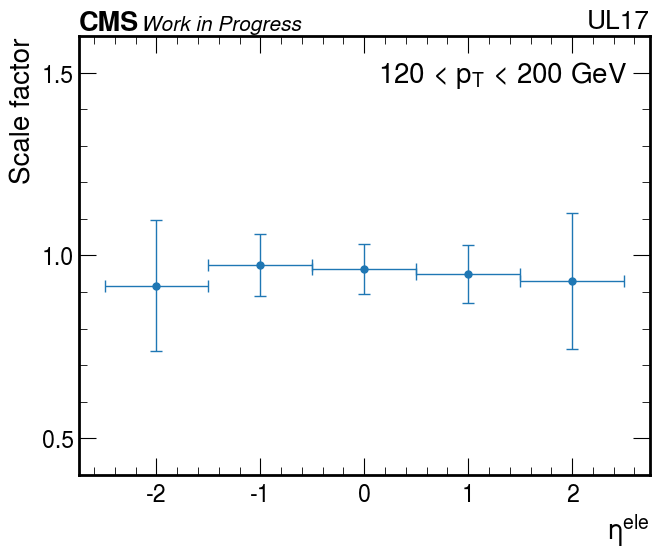

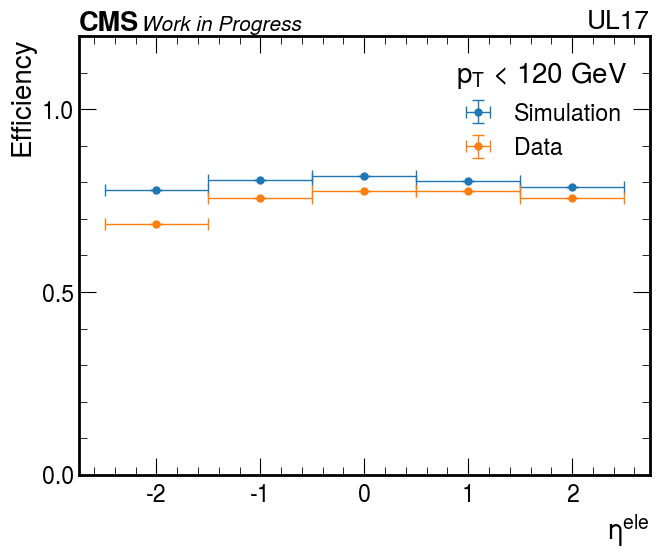

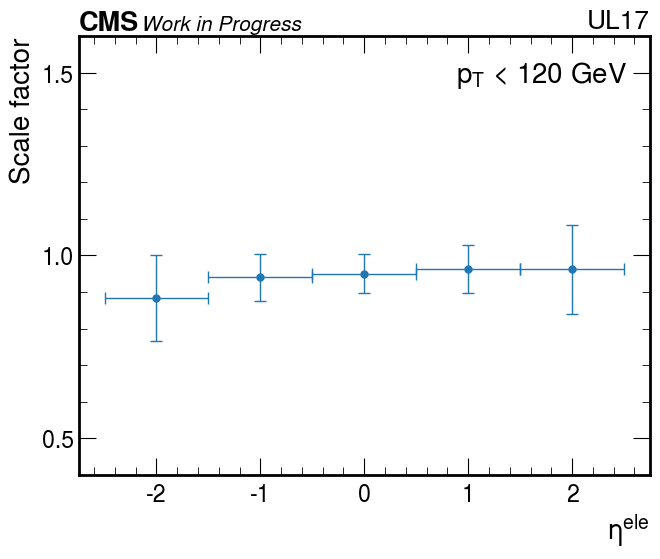

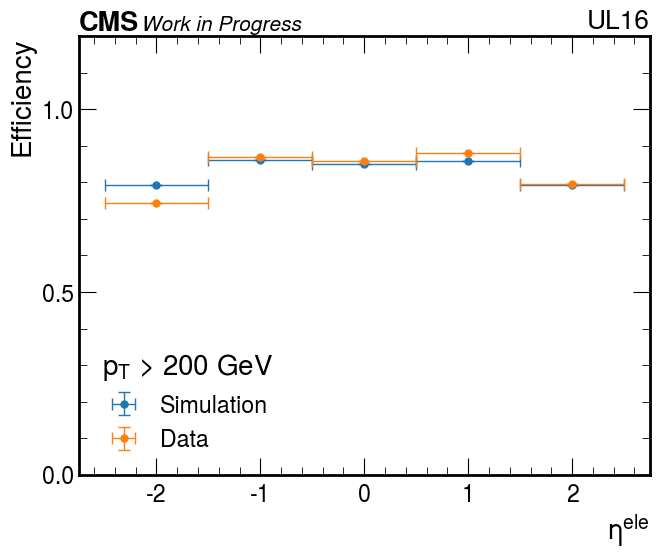

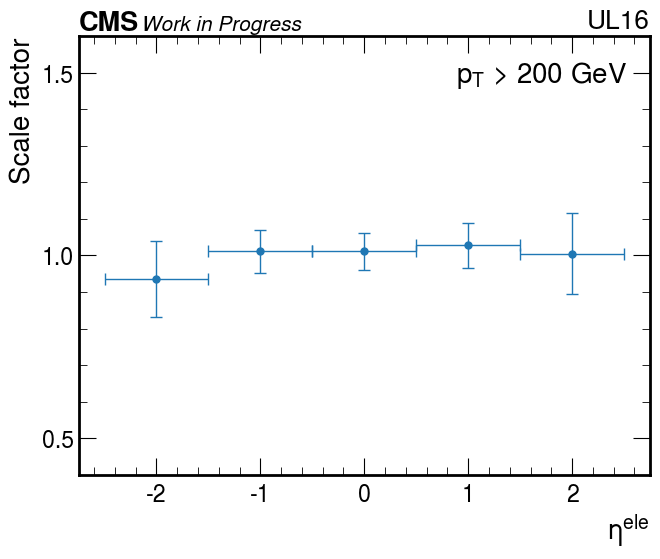

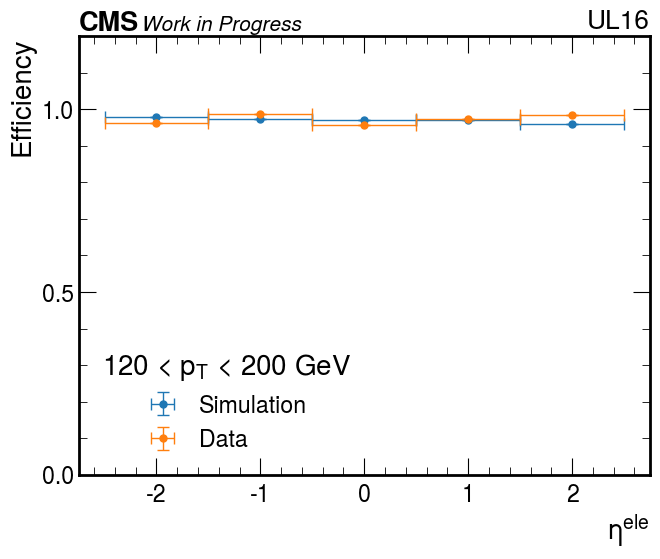

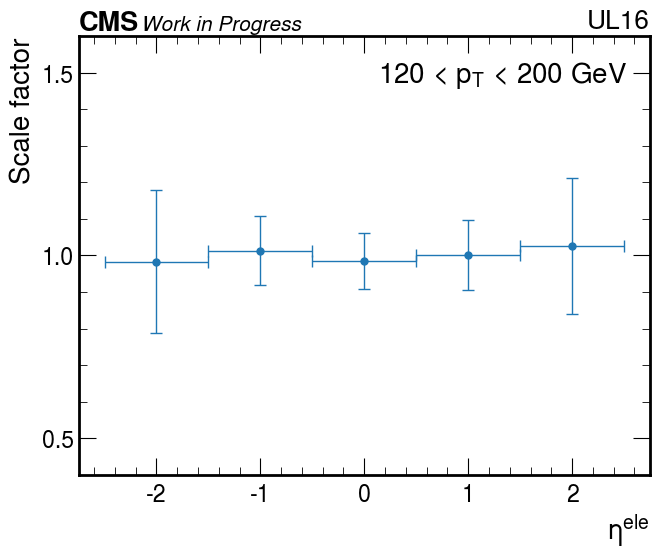

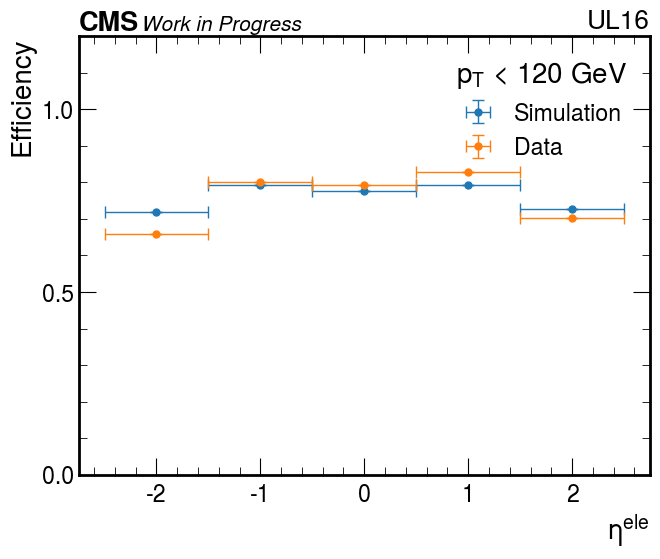

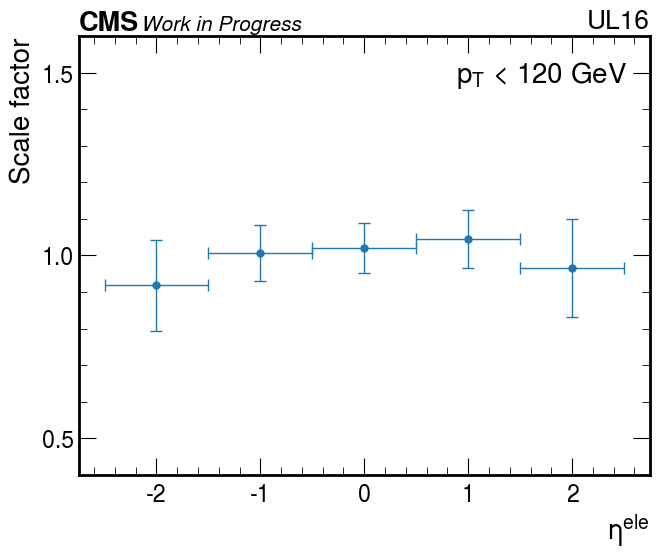

In [31]:
plt.rcParams.update({"font.size": 20})

ptcuts = [
    "200+",
    "200-",    
    "120",
]

for yearkey in years:
    print(f"Processing year {yearkey}")

    for j, ptcut in enumerate(ptcuts):
        print(f"ptcut {ptcut}")    
    
        hists = hist2.Hist(
            hist2.axis.StrCategory([], name='samples', growth=True),
            hist2.axis.StrCategory([], name='trigger', growth=True),    
            hist2.axis.Regular(5, -2.5, 2.5, name='lepeta', label=r'$\eta^{ele}$'),
            hist2.axis.Variable(np.linspace(30, 430, 21), name='leppt', label=r'$p_T^{ele}$ [GeV]', overflow=False),
        )

        for sample_label in samples_dict[year]:
            lep_eta, lep_pt = [], []

            trgs = {}
            for trg in HLT_triggers[yearkey]:
                trgs[trg] = []

            for year in years[yearkey]:
                for sample in samples_dict[year][sample_label]:
                    for i, file in enumerate(glob.glob(f"../eos/July23_triggerSF_{year}/{sample}/outfiles/*")):
                        with open(file, "rb") as f:
                            out = pkl.load(f)[year][sample]["skimmed_events"]["ele"]

                        lep_eta += list(out["vars"]["ele_eta"])
                        lep_pt += list(out["vars"]["ele_pt"])

                        for trg in HLT_triggers[yearkey]:
                            trgs[trg] += list(out["triggers"][trg])
            
            # convert lists to numpy arrays
            lep_eta = np.array(lep_eta)
            lep_pt = np.array(lep_pt)                
            
            for trg in HLT_triggers[yearkey]:
                trgs[trg] = np.array(trgs[trg])

            # apply pt cut                
            if ptcut == "120":
                msk_leppt = (lep_pt < 120)
            elif ptcut == "200-":
                msk_leppt = (lep_pt > 120) & (lep_pt < 200)
            elif ptcut == "200+":
                msk_leppt = (lep_pt < 200)

            leg = legend_lab[ptcut]

            # save events before trigger        
            hists.fill(
                samples=sample_label,        
                trigger="before_triggers",
                leppt=lep_pt[msk_leppt],
                lepeta=lep_eta[msk_leppt],
            )

            ########## build the OR of all triggers
            msk_trg = np.zeros(len(lep_pt[msk_leppt]), dtype="bool")

            for trg in trgs:
                msk_trg = msk_trg | trgs[trg][msk_leppt]

            # save events after OR of triggers  
            hists.fill(
                samples=sample_label,
                trigger="or_of_triggers",        
                leppt=lep_pt[msk_leppt][msk_trg],
                lepeta=lep_eta[msk_leppt][msk_trg],
            )
            
        print("-------------------------------------")        


        ########## plot the eff
        fig, ax = plt.subplots(figsize=(7,6))

        bin_size = (hists.axes["lepeta"].edges[1] - hists.axes["lepeta"].edges[0])

        for sample_label in ["Simulation", "Data"]:

            den = hists[{"samples": sample_label, "trigger": "before_triggers", 'leppt': sum}]
            num = hists[{"samples": sample_label, "trigger": "or_of_triggers", 'leppt': sum}]

            eff = num/den
            hep.histplot(eff,
                         ax = ax,
                         label=sample_label,
                         histtype='errorbar', 
        #                  yerr=get_yerr(num, den),
                         yerr=0,                 
                         xerr=bin_size/2,
                         capsize=4, 
                         elinewidth=1,
                         flow=None,             
            )

        ax.set_ylim(0,1.2)
        ax.set_yticks([0, 0.5, 1])
        ax.legend(title=leg)
        ax.set_ylabel("Efficiency")
        hep.cms.lumitext(
            yearkey, ax=ax, fontsize=20
        )
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)

        plt.tight_layout()
        plt.savefig(f"{outdir}/eletriggerSF/{yearkey}/{yearkey}_eff_{ptcut}.pdf")

        ########## plot the SF
        fig, ax = plt.subplots(figsize=(7,6))

        bin_size = (hists.axes["lepeta"].edges[1] - hists.axes["lepeta"].edges[0])

        den = hists[{"samples": "Simulation", "trigger": "before_triggers", 'leppt': sum}]
        num = hists[{"samples": "Simulation", "trigger": "or_of_triggers", 'leppt': sum}]
        eff_MC = (num / den)
        unc_MC = unc_fraction(num.values(), den.values())

        den = hists[{"samples": "Data", "trigger": "before_triggers", 'leppt': sum}]
        num = hists[{"samples": "Data", "trigger": "or_of_triggers", 'leppt': sum}]
        eff_Data = num / den
        unc_Data = unc_fraction(num.values(), den.values())

        sf = eff_Data/eff_MC
        sf_unc = unc_fraction(eff_Data.values(), eff_MC.values(), unc_num=unc_Data, unc_den=unc_MC)

        hep.histplot(sf,
                     ax = ax,
                     histtype='errorbar', 
                     yerr=sf_unc,
                     xerr=bin_size/2,
                     capsize=4, 
                     elinewidth=1,
                     flow=None,             
        )

        ax.set_ylim(0.4,1.6)
        ax.set_yticks([0.5, 1, 1.5])
        ax.legend(title=leg)
        ax.set_ylabel("Scale factor")
        hep.cms.lumitext(
            yearkey, ax=ax, fontsize=20
        )
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)

        plt.tight_layout()        
        plt.savefig(f"{outdir}/eletriggerSF/{yearkey}/{yearkey}_sf_{ptcut}.pdf")   
        
        SF[yearkey][j] = sf.values()

# SF

In [19]:
SF

{'UL18': array([[0.98379649, 1.0005387 , 0.97729768, 0.9881872 , 0.99789482],
        [1.02083724, 1.00569659, 0.99931007, 0.97253711, 1.02816501],
        [0.9582612 , 0.99847442, 0.9663244 , 1.00026573, 0.97930598]]),
 'UL17': array([[0.89662712, 0.95327144, 0.95553825, 0.96084622, 0.94787736],
        [0.91771569, 0.97330338, 0.9628086 , 0.94945886, 0.93074193],
        [0.88346762, 0.93986709, 0.95049357, 0.96395947, 0.96216591]]),
 'UL16': array([[0.93533661, 1.01108228, 1.01107286, 1.02789081, 1.00422882],
        [0.98220745, 1.01275276, 0.98584499, 1.00147192, 1.02677684],
        [0.91866763, 1.00740741, 1.02089672, 1.04459947, 0.96555385]])}

In [34]:
def plot_matrix(M, yearkey):
    fig, ax = plt.subplots(figsize=(14,8))

    im = ax.imshow(M, vmax=1, vmin=0)#, cmap='hot', interpolation='nearest')

    ax.set_xticks(ticks=np.arange(-0.5, (len(etabinning)-1), 1), labels=np.round(etabinning,2))
    ax.set_yticks(ticks=np.arange(-0.5, (len(ptbinning)-1), 1), labels=np.round(ptbinning,2))

    ax.tick_params(axis='x', which='major', pad=8)
    ax.tick_params(axis='y', which='major', pad=8)

    # Loop over data dimensions and create text annotations.
    for i in range(len(ptbinning)-1):
        for j in range(len(etabinning)-1):
            text = ax.text(j, i, str(np.round(M[i, j],3)), ha="center", va="center", fontsize=20)

    ax.set_xlabel(r"$\eta^{ele}$")            
    ax.set_ylabel(r"$p_T^{ele}$ [GeV]")

    plt.colorbar(im, shrink=0.6)
    plt.tight_layout()

    ax.set_title(f"Trigger efficiency SF for UL{yearkey[2:]}", pad=20)

    plt.savefig(f"{outdir}/eletriggerSF/{yearkey}/{yearkey}_2dSF.pdf")    

# PATH = f"/Users/fmokhtar/Desktop/AN_2024/fakes/"            

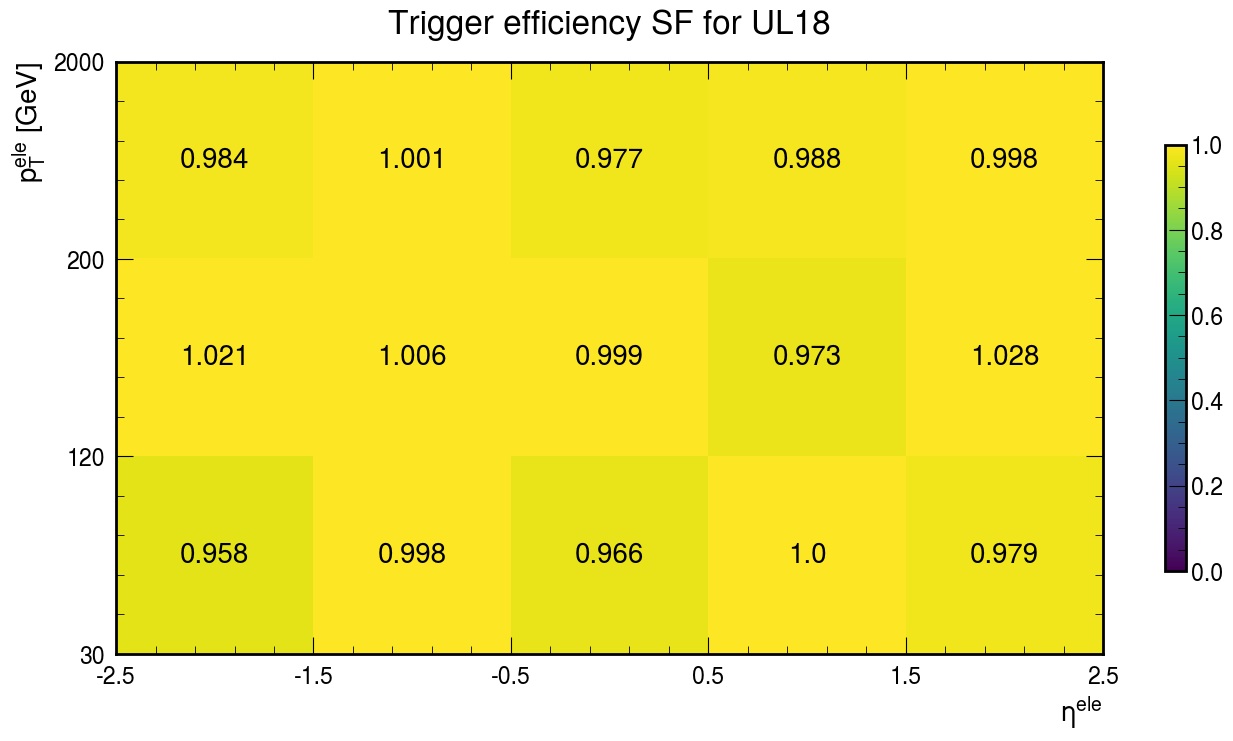

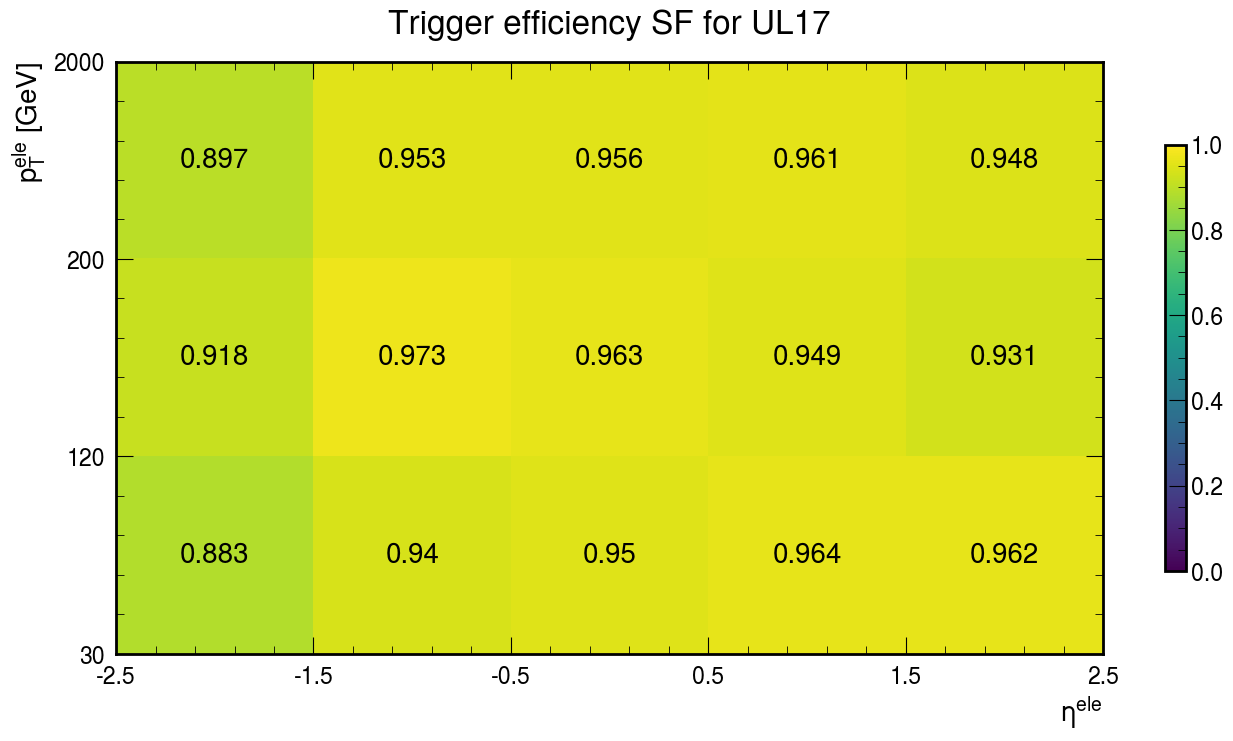

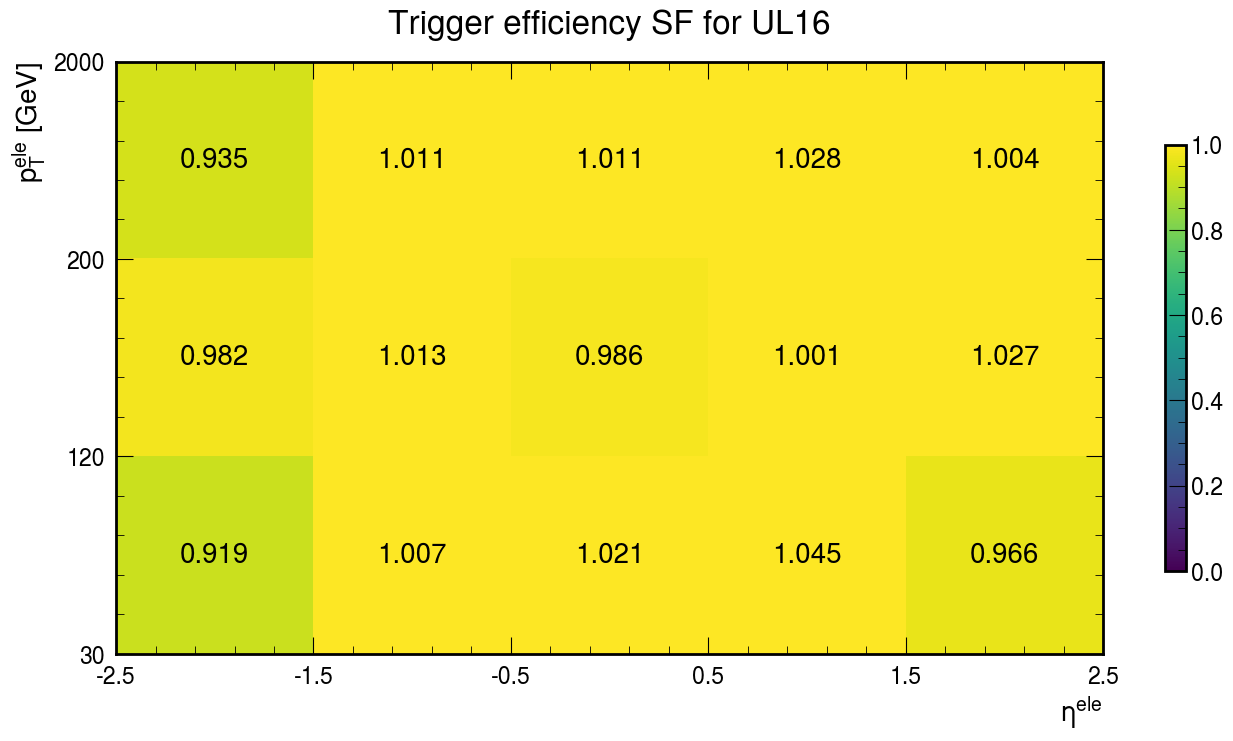

In [35]:
for yearkey in years:
    plot_matrix(SF[yearkey], yearkey)

In [36]:
with open("trg_eff_SF.pkl", "wb") as f:
    pkl.dump(SF, f)